# MLFlow Tutorial

## What is it?

MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry

## What we're interested in

### MLFlow Tracking

MLflow Tracking is an API and UI for logging parameters, code versions, metrics and output files when running your machine learning code to later visualize them.

### MLflow Models

MLflow Models is a convention for packaging machine learning models in multiple formats called "flavors". MLflow offers a variety of tools to help you deploy different flavors of models

![Title](mlflow-web-ui.png)


## Installation

Recommended: Install the same MLFlow version that is deployed on your k8s cluster

## Setup

There is not need to run a local instance, as there is one deployed on the k8s cluster.

MLFlow automatically looks for the following environment variables:
- MLFLOW_TRACKING_URI = 
- MLFLOW_S3_ENDPOINT_URL = 
- AWS_ACCESS_KEY_ID=
- AWS_SECRET_ACCESS_KEY=

## MLFlow Tracking

### Model training pipeline goal
ML pipelines can broken down into 
- Loading data
- Preprocessing / Splits
- Training Model
- Model Validation

When using MLFlow we should endup with a main function like:
```
def main(config):
    mlflow_client.start_run()
    load_data()
    process_features()
    train_model() 
    model_validation()
    mlflow_client.end_run()

```

Of which, MLFlow affects two of the stages 
- train_model: Logging hyperparameters, saving models, model schema, tags & descriptions
- model_validation: Logging metrics, visualisations & explainations

### Libraries for the tutorial

https://gist.github.com/heitorlessa/5b709df96ea6ac5ddc600545c0683d3b

In [8]:
import itertools
import logging

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn
from dotenv import load_dotenv
from mlflow.entities.lifecycle_stage import LifecycleStage
from mlflow.exceptions import MlflowException
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

load_dotenv()

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s:%(levelname)s:%(message)s",
    datefmt="%Y-%m-%d %I:%M:%S%p",
)


### Creating an experiment
- Experiments are identified by their name or id, both which are unique
- We can use the search_experiments method to view existing experiments
- We want to group models which can be compared under the same experiment

In [9]:
# Client will automatically read the environment variables listed above
mlflow_client = MlflowClient()


In [10]:
# We can list all the experiments that have been created
experiments = mlflow_client.search_experiments()
experiment_list = []
for i in experiments:
    experiment_list.append(dict(i))
df = pd.DataFrame(experiment_list)
df

,artifact_location,creation_time,experiment_id,last_update_time,lifecycle_stage,name,tags
0,s3://mlflow/0,NaN,0,NaN,active,Default,{}
1,s3://mlflow/1,1.671197e+12,1,1.671197e+12,active,Document-Extractor,{}


In [11]:
# Move to a common library
def create_experiment(mlflow_client, experiment_name):
    try:
        experiment_id = mlflow_client.create_experiment(experiment_name)
        logging.info(
            f"Experiment {experiment_name} created with id {experiment_id}"
        )
    except MlflowException as create_error:

        experiment = mlflow_client.get_experiment_by_name(experiment_name)
        if experiment.lifecycle_stage == LifecycleStage.DELETED:
            logging.error(f"Experiment {experiment_name} already DELETED")
            raise
        experiment_id = experiment.experiment_id
        logging.info(
            f"Experiment {experiment_name} exists with id {experiment_id}"
        )
    return experiment_id


In [14]:
experiment_id = create_experiment(mlflow_client, "Default")
# Tags are arbitary key value pairs
tags = {
    "calibration_date": "2021-12-31",
}
run = mlflow.start_run(experiment_id=experiment_id, tags=tags)


2022-12-18 06:16:19PM:INFO:Experiment Default exists with id 0


### Starting a run
I recommend using:
```
run = mlflow.start_run(experiment_id=experiment_id, tags=tags)
train_model()
mlflow.end_run()
```

An alternative approach is to use:
```
with mlflow.start_run(experiment_id=experiment_id, tags=tags) as run:
    train_model()

```

But anything to have less indents

You should have a run that you can see in the MLFlow UI now. 

It won't be interesting as we haven't logged anything, so let's keep going

### Training an ML Model

- Hyperparameters, Saving Model, Model Schema, Tags & Descriptions
- Using sklearn's iris dataset to train a simple classifier
- MLFlow supports many many libraries: https://mlflow.org/docs/latest/python_api/index.html
- If it's not listed you can probably use the pyfunc

In [15]:
iris_dataset = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset["data"],
    iris_dataset["target"],
    test_size=0.25,
    random_state=0,
)
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [16]:
# Log any dictionary
mlflow.log_params(model.get_params())
# Infer signature works best when the data is in a pd.DataFrame
model_signature = infer_signature(X_train, y_train)
# Saves model as pkl file
# You can customise the function depending on the model library. MLFlow supports most
logged_model_info = mlflow.sklearn.log_model(
    model, "sklearn_classifier", signature=model_signature
)


/Users/yeungadrian/Library/Caches/pypoetry/virtualenvs/{{cookiecutter-directory-name}}-ChGLXcDN-py3.9/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2022-12-18 06:16:30PM:INFO:Found credentials in environment variables.


### Model Validation

We want to save model metrics, visualisations and explainability to ensure that our model whether our model is useful

- AUC
- Confusion Matrix
- Prediction distributions
- Shap values
- Feature importance

Confusion matrix example illustrated below, but customise it to your project

Read docs for all methods: https://mlflow.org/docs/latest/python_api/mlflow.html

In [17]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize=False,
    title="Confusion matrix",
):
    """
    Generate multiclass confusion matrix plot

    Args:
        cm (np.ndarray): Confusion matrix results
        classes (List): List of all classes
        normalize (bool=False): Show normalised results
        title (str="Confusionmatrix"): Plot title

    Returns:
        plt.figure: confusion matrix plot

    """
    cmap = plt.cm.Blues
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return fig


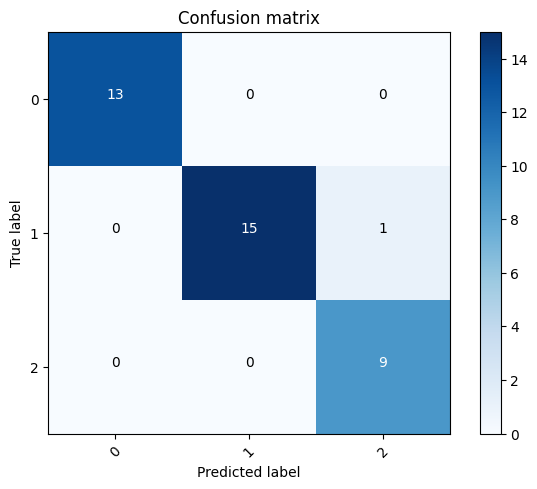

In [18]:
y_pred = model.predict(X_test)
score = metrics.balanced_accuracy_score(y_test, y_pred)
# Log individual metric as key, value pair
# Use log_metrics to log dictionary
mlflow.log_metric("balanced_accuracy_score", score)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_png = plot_confusion_matrix(cm, classes=list(np.unique(y_test)))
# Log any matplotlib plot
mlflow.log_figure(cm_png, "confusionmatrix.png")


In [19]:
## End the run
mlflow.end_run()


# MLFlow Registry

Read: https://mlflow.org/docs/latest/model-registry.html#ui-workflow
and use the UI to register models and transition stages.

Once you're comfortable with what's going on, you can use the api to automate it for you

Once your model is mature, you should add automatic promotion subject the model passing certain validation criteria:

e.g. AUROC > 0.85

## Model Registery
This is MLFlow's centralised stored of models

Each model's unique key is the name

In [20]:
# Check currently registered models
client = MlflowClient()
registered_models = []
for rm in client.search_registered_models():
    registered_models.append(dict(rm))
    
pd.DataFrame(registered_models)

,creation_timestamp,description,last_updated_timestamp,latest_versions,name,tags
0,1671221168509,,1671235556460,[<ModelVersion: creation_timestamp=16712214242...,iris_classifer,{}


In [ ]:
# or filter on specific model
# This will be useful for transitioning models

registered_models = []
# String within a string is intended approach
for rm in client.search_registered_models(filter_string="name = 'iris_classifer'")[0].latest_versions:
    registered_models.append(dict(rm))
    
pd.DataFrame(registered_models)

,creation_timestamp,current_stage,description,last_updated_timestamp,name,run_id,run_link,source,status,status_message,tags,user_id,version
0,1671221424237,None,,1671221424237,iris_classifer,,,runs:/7201293f769c4a1288a804aaf6e055fc/sklearn...,READY,,{},,1
1,1671221432212,Archived,,1671221576903,iris_classifer,,,runs:/7201293f769c4a1288a804aaf6e055fc/sklearn...,READY,,{},,2
2,1671221517201,Production,,1671221576903,iris_classifer,,,runs:/7201293f769c4a1288a804aaf6e055fc/sklearn...,READY,,{},,3


: 

: 

: 

### Registering a new model

In [21]:
model_name = "iris_classifer"
model_description ="iris flower classifier"

In [22]:
# Similar to experiments, create if not exists
def create_registered_model(mlflow_client, model_name, model_description=None):
    try:
        mlflow_client.create_registered_model(model_name)
        logging.info(
            f"Registered model {model_name} created"
        )
    except MlflowException as create_error:
        logging.info(f"Registered model {model_name} already exists")

    return None


In [23]:
create_registered_model(mlflow_client, model_name, model_description = model_description)


2022-12-18 06:18:32PM:INFO:Registered model iris_classifer already exists


### Promoting an experiment run to the model registry
Once you are happy that your model is performant or you want to test it end to end, we can promote models to the registry
To do that we need the name of the model in the model registry and the model uri
The model uri is returned when logging a model, alternatively

We could use the model validation metrics to automatically promote the model 

In [24]:
# Using the model uri
result = client.create_model_version(
    model_name,
    logged_model_info.model_uri,
    tags = {
    },
    description = "",
    )

2022/12/18 18:18:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: iris_classifer, version 8


### Transitioning model stage
We can load models based off their version number or stage
It's much easier to always load the model from the "production" stage, rather than take a specific version
We can get the model version when we promote it from an experiment or we can look through the search_registered_models results earlier

In [25]:
# Need to specify model to promote
#Archive existing versions or you can have multiple models in prod
transition_results = client.transition_model_version_stage(
    name=model_name,
    version=result.version,
    stage="Production",
    archive_existing_versions=True
)

In [26]:
X_train

array([[5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [6.8, 3. , 5.5, 2.1],
       [4.7, 3.2, 1.3, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5. , 3.5, 1.6, 0.6],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 2. , 3.5, 1. ],
       [6.5, 3. , 5.5, 1.8],
       [6.7, 3.3, 5.7, 2.5],
       [6. , 2.2, 5. , 1.5],
       [6.7, 2.5, 5.8, 1.8],
       [5.6, 2.5, 3.9, 1.1],
       [7.7, 3. , 6.1, 2.3],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.4, 3.8, 1.1],
       [6.3, 2.7, 4.9, 1.8],
       [6.3, 2.8, 5.1, 1.5],
       [4.9, 2.5, 4.5, 1.7],
       [6.3, 2.5, 5. , 1.9],
       [7. , 3.2, 4.7, 1.4],
       [6.5, 3. , 5.2, 2. ],
       [6. , 3.4, 4.5, 1.6],
       [4.8, 3.1, 1.6, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [5.6, 2.7, 4.2, 1.3],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [6.1, 3. , 4.6, 1.4],
       [7.2, 3.2, 6. , 1.8],
       [5.3, 3.7, 1.5, 0.2],
       [4.3, 3. , 1.1, 0.1],
       [6.4, 2.7, 5.3, 1.9],
       [5.7, 3. , 4.2, 1.2],
       [5.4, 3